In [131]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd

import requests
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import scipy.stats as ss

sys.path.append('../../src/')
import toolbox

In [132]:
r = requests.get('http://data.thecrix.de/data/crix11.json').json()
VCRIX = pd.DataFrame(r)
VCRIX.date = pd.to_datetime(VCRIX.date)

# VCRIX.n = VCRIX.n.astype(np.int)

_id = VCRIX.date > '20180614'

VCRIX = VCRIX.loc[_id, :]

VCRIX.n = list(range(len(VCRIX)))

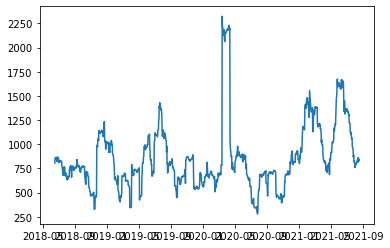

In [133]:
plt.plot(VCRIX.date, VCRIX.vcrix)

# thres = np.quantile(VCRIX.vcrix , 0.90)

thres = 1000
i = VCRIX.vcrix >=thres
# plt.scatter(VCRIX.date.loc[i], VCRIX.vcrix.loc[i], color='red')

stress_period = VCRIX.loc[i, :]

# for i in range(len(stress_period)-1):
#     start = training_Clayton.Date.iloc[i]
#     end =  training_Clayton.Date.iloc[i+1]
#     _end = end
#     plt.axvspan(start, end,facecolor='black', alpha=.2)

In [134]:
stress_period.date

1459   2018-11-26
1460   2018-11-27
1461   2018-11-28
1462   2018-11-29
1463   2018-11-30
          ...    
2424   2021-07-18
2425   2021-07-19
2426   2021-07-20
2427   2021-07-21
2428   2021-07-22
Name: date, Length: 283, dtype: datetime64[ns]

In [135]:
last_n = stress_period.iloc[0,:].n

start_arr = [stress_period.iloc[0,:].date]
end_arr = []

for row_i in range(1, len(stress_period)-2):
    
    last_n = stress_period.iloc[row_i-1,:].n
    n  = stress_period.iloc[row_i,:].n
    next_n = stress_period.iloc[row_i+1,:].n
    next_next_n = stress_period.iloc[row_i+2,:].n

    
    if (next_n-n>1):
        end_arr.append(stress_period.iloc[row_i,:].date)

    if n-last_n>1:
        start_arr.append(stress_period.iloc[row_i,:].date)

        
end_arr.append(stress_period.iloc[-1,:].date)

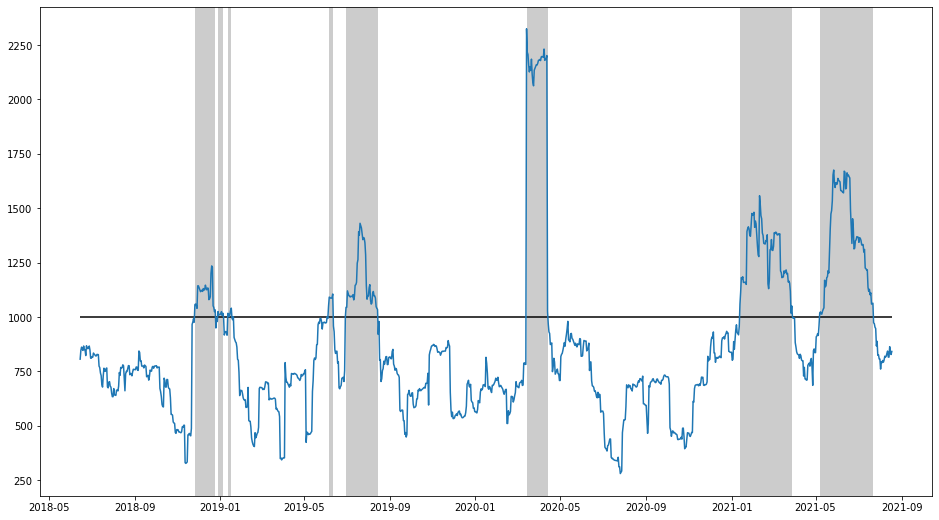

In [136]:
plt.figure(figsize=(16,9))
plt.plot(VCRIX.date, VCRIX.vcrix)

plt.hlines(y=thres, xmin=VCRIX.iloc[0,:].date, xmax=VCRIX.iloc[-1,:].date)


# plt.plot(stress_period.date, stress_period.vcrix)
for i in range(len(start_arr)):
    start = start_arr[i]
    end =  end_arr[i]
    plt.axvspan(start, end, facecolor='black', alpha=.2)

In [137]:
np.array(end_arr)  - np.array(start_arr) 

array([Timedelta('29 days 00:00:00'), Timedelta('7 days 00:00:00'),
       Timedelta('5 days 00:00:00'), Timedelta('0 days 00:00:00'),
       Timedelta('0 days 00:00:00'), Timedelta('6 days 00:00:00'),
       Timedelta('45 days 00:00:00'), Timedelta('30 days 00:00:00'),
       Timedelta('75 days 00:00:00'), Timedelta('76 days 00:00:00')],
      dtype=object)

In [138]:
for i in range(len(start_arr)):
    print(start_arr[i], end_arr[i])

2018-11-26 00:00:00 2018-12-25 00:00:00
2018-12-29 00:00:00 2019-01-05 00:00:00
2019-01-12 00:00:00 2019-01-17 00:00:00
2019-01-20 00:00:00 2019-01-20 00:00:00
2019-06-03 00:00:00 2019-06-03 00:00:00
2019-06-05 00:00:00 2019-06-11 00:00:00
2019-06-30 00:00:00 2019-08-14 00:00:00
2020-03-14 00:00:00 2020-04-13 00:00:00
2021-01-13 00:00:00 2021-03-29 00:00:00
2021-05-07 00:00:00 2021-07-22 00:00:00


In [139]:
result_names = ['BBT_Tiingo',
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',
                'BBT_future_BITX',
                'BBT_future_BITW20', 
                'BBT_future_BITW70', 
                'BBT_future_BITW100', 
                'BBT_future_CRIX']

# result_names = ['BBT_future_CRIX']

coin_names = ['bitcoin', 'ada', 'eth', 'ltc', 'xrp',
              'BITX', 'BITW20', 'BITW70', 'BITW100', 'CRIX']

i = 2
data_name = result_names[i]
coin_name = coin_names[i]
# objective = 'ERM k=10'
# objective = 'ES q=0.01'
objective = 'VaR q=0.01'

print(data_name, coin_name, objective)

rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, objective))

BBT_future_Tiingo_eth eth VaR q=0.01


In [140]:
rm_arr =  [ 'ERM k=10', 'ES q=0.01', 'ES q=0.05', 'VaR q=0.01', 'VaR q=0.05', 'Variance']


for i, data_name in enumerate(result_names):

    rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, rm_arr[0]))
    SS = summary_statistics(rh_df.rh, rm_arr[0])
    
    CH = create_CH(data_name, coin_names[i])
    
    for rm in rm_arr[1:]:
        rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, rm))
        SS = SS.append(summary_statistics(rh_df.rh, rm))
    
    SS = SS.append(summary_statistics(CH.rh, 'cross hedge'))

#     print('\\begin{table}[h!]\n\\begin{center}\n\\noindent\makebox[\\textwidth]{'+
#               SS.to_latex()
#              +
#              '}\\end{center}\\caption{\\label{tab:table%i} PnL %s}\n\\end{table}'%(i, coin_names[i]))


In [141]:
rh_df.Date = pd.to_datetime(rh_df.Date.apply(lambda x: x[:10]))

In [142]:
s_id = rh_df.Date.apply(lambda x: x in list(stress_period.date))

In [143]:
i=2
data_name = result_names[i]
coin_name = coin_names[i]


train_path = '../../processed_data/%s/train/'%data_name
test_path = '../../processed_data/%s/test/'%data_name

files = [f for f in os.listdir(train_path) if f.endswith('.csv')]

test_arr = []

for f in files:
    train = pd.read_csv(train_path+f)
    test = pd.read_csv(test_path+f)
    rs = train.iloc[:,-1]
    rf = train.iloc[:,-2]
    rho = np.corrcoef(rs,rf)[0,1]
    rs_std = np.std(rs)
    rf_std = np.std(rf)
    h = rho*rs_std/rf_std
    test.loc[:,'h_CH'] = h
    test_arr.append(test)
    
CH = pd.concat(test_arr)
CH.Date = pd.to_datetime(CH.Date)
CH = CH.sort_values('Date', ascending=False)

CH.reset_index(drop=True, inplace=True)
CH.loc[:,'rh'] = CH.loc[:,'log return %s'%coin_name] - CH.loc[:,'h_CH']* CH.loc[:,'log return future']

In [144]:
def create_CH(data_name, coin_name):
    train_path = '../../processed_data/%s/train/'%data_name
    test_path = '../../processed_data/%s/test/'%data_name

    files = [f for f in os.listdir(train_path) if f.endswith('.csv')]

    test_arr = []

    for f in files:
        train = pd.read_csv(train_path+f)
        test = pd.read_csv(test_path+f)
        rs = train.iloc[:,-1]
        rf = train.iloc[:,-2]
        rho = np.corrcoef(rs,rf)[0,1]
        rs_std = np.std(rs)
        rf_std = np.std(rf)
        h = rho*rs_std/rf_std
        test.loc[:,'h_CH'] = h
        test_arr.append(test)

    CH = pd.concat(test_arr)
    CH.Date = pd.to_datetime(CH.Date)
    CH = CH.sort_values('Date', ascending=False)

    CH.reset_index(drop=True, inplace=True)
    CH.loc[:,'rh'] = CH.loc[:,'log return %s'%coin_name] - CH.loc[:,'h_CH']* CH.loc[:,'log return future']
    
    return CH

avg h 
copula     :0.953 
cross hedge:1.002


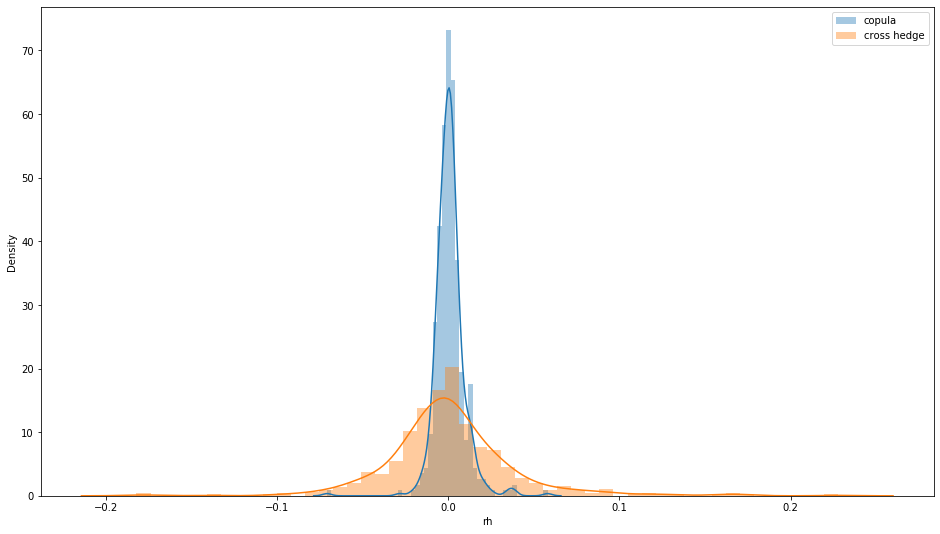

In [145]:
plt.figure(figsize=(16,9))

# sns.distplot(rh_df.new_rh)
sns.distplot(rh_df.rh, label='copula')
sns.distplot(CH.rh, label='cross hedge')
plt.legend()
print('avg h', '\ncopula     :%.3f'%np.mean(rh_df.h),  '\ncross hedge:%.3f'%np.mean(CH.h_CH))

In [146]:
def risk_statistics(rh, name):

    ERM = toolbox.ERM_estimate_trapezoidal(10, rh)
    ES1 = toolbox.ES(0.01, rh)
    ES5 = toolbox.ES(0.05, rh)
    VaR1 = toolbox.VaR(0.01, rh)
    VaR5 = toolbox.VaR(0.05, rh)
    Var = toolbox.Variance(rh)
    
    _dict = {'ERM':ERM, 'ES1':ES1, 'ES5':ES5, 'VaR1':VaR1, 
             'VaR5':VaR5, 'Var':Var}
    
    return pd.DataFrame([_dict], [name])


# Table 1a: Moments, dependency with future, start and end
def summary_statistics(rs, name):
    
    m1 = np.mean(rs)
    m2 = np.std(rs)
    m3 = ss.skew(rs) # Pearson coefficient of skewness
    m4 = ss.kurtosis(rs) # Pearson coefficient of kurtosis

    _max = np.max(rs)
    _min = np.min(rs)

    
    _dict = {'Mean':m1, 'Std':m2, 'Skew':m3, 'Kurt':m4, 
            'Max':_max, 'Min':_min}
    
    return pd.DataFrame([_dict], [name])

In [147]:
print('Summary Statistics', coin_name, objective)
summary_statistics(rh_df.rh, 'copula')\
    .append(summary_statistics(CH.rh, 'cross hedge'))\
    .append(summary_statistics(rh_df.rs, 'spot'))

Summary Statistics eth VaR q=0.01


,Mean,Std,Skew,Kurt,Max,Min
copula,0.000826,0.008816,0.074658,15.114503,0.058027,-0.070768
cross hedge,0.000813,0.037976,0.801399,6.446427,0.227673,-0.182093
spot,0.003690,0.044606,-0.798145,4.944678,0.156166,-0.271385


In [149]:
print('Summary Statistics', coin_name, objective)
summary_statistics(rh_df.loc[s_id, 'rh'], 'copula in stress period')\
    .append(summary_statistics(CH.loc[s_id,'rh'], 'cross hedge in stress period'))\
    .append(summary_statistics(rh_df.loc[s_id,'rs'], 'spot in stress period'))

Summary Statistics eth VaR q=0.01


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [150]:
print(coin_name, objective)
copula_vs_crosshedge = risk_statistics(rh_df.rh, 'copula')\
    .append(risk_statistics(CH.rh, 'cross hedge'))
    
diff = pd.DataFrame({'% relative diff':100*(copula_vs_crosshedge.iloc[0,:]-copula_vs_crosshedge.iloc[1,:])/copula_vs_crosshedge.iloc[1,:]}).T
copula_vs_crosshedge = copula_vs_crosshedge.append(diff).append(risk_statistics(rh_df.rs, 'spot'))
copula_vs_crosshedge


eth VaR q=0.01


,ERM,ES1,ES5,VaR1,VaR5,Var
copula,0.009913,0.031350,0.016792,0.016521,0.009377,0.000078
cross hedge,0.049662,0.130841,0.078328,0.085429,0.050916,0.001442
% relative diff,-80.039379,-76.039425,-78.562106,-80.660997,-81.583284,-94.611437
spot,0.064772,0.178374,0.114805,0.139618,0.062770,0.001990


In [151]:
print(coin_name, objective)
copula_vs_crosshedge_stressperiod = risk_statistics(rh_df.loc[s_id, 'rh'], 'copula in stress period')\
    .append(risk_statistics(CH.loc[s_id,'rh'], 'cross hedge in stress period'))

diff = pd.DataFrame({'% relative diff':100*(copula_vs_crosshedge_stressperiod.iloc[0,:]-copula_vs_crosshedge_stressperiod.iloc[1,:])/copula_vs_crosshedge_stressperiod.iloc[1,:]}).T
copula_vs_crosshedge_stressperiod = copula_vs_crosshedge_stressperiod.append(diff).append(risk_statistics(rh_df.loc[s_id,'rs'], 'spot in stress period'))
list(copula_vs_crosshedge.columns)

eth VaR q=0.01


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [152]:
rm_arr =  [ 'ERM k=10', 'ES q=0.01', 'ES q=0.05', 'VaR q=0.01', 'VaR q=0.05', 'Variance']
# results = {}

for i in range(len(result_names)):
    data_name = result_names[i]
    coin_name = coin_names[i]
    CH = create_CH(data_name, coin_name)

    _index = ['copula', 'cross hedge', '% relative diff', 'spot']
    _index_stress = ['copula in stress period',
             'cross hedge in stress period',
             '% relative diff',
             'spot in stress period']
    columns = ['ERM', 'ES1', 'ES5', 'VaR1', 'VaR5', 'Var']
    copula_vs_crosshedge_result = pd.DataFrame(index=_index, columns=columns)
    copula_vs_crosshedge_stressperiod_result = pd.DataFrame(index=_index_stress, columns=columns)

    for j, objective in enumerate(rm_arr):
        rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, objective))
#         print(data_name, coin_name, objective)
        
        copula_vs_crosshedge = risk_statistics(rh_df.rh, 'copula')\
        .append(risk_statistics(CH.rh, 'cross hedge'))
    
        diff = pd.DataFrame({'% relative diff':100*(copula_vs_crosshedge.iloc[0,:]-copula_vs_crosshedge.iloc[1,:])/copula_vs_crosshedge.iloc[1,:]}).T
        copula_vs_crosshedge = copula_vs_crosshedge.append(diff).append(risk_statistics(rh_df.rs, 'spot'))
        copula_vs_crosshedge_result.iloc[:,j] = copula_vs_crosshedge.iloc[:,j]
        
        
        copula_vs_crosshedge_stressperiod = risk_statistics(rh_df.loc[s_id, 'rh'], 'copula in stress period')\
        .append(risk_statistics(CH.loc[s_id,'rh'], 'cross hedge in stress period'))

        diff = pd.DataFrame({'% relative diff':100*(copula_vs_crosshedge_stressperiod.iloc[0,:]-copula_vs_crosshedge_stressperiod.iloc[1,:])/copula_vs_crosshedge_stressperiod.iloc[1,:]}).T
        copula_vs_crosshedge_stressperiod = copula_vs_crosshedge_stressperiod.append(diff).append(risk_statistics(rh_df.loc[s_id,'rs'], 'spot in stress period'))
        copula_vs_crosshedge_stressperiod_result.iloc[:,j] = copula_vs_crosshedge_stressperiod.iloc[:,j]

    copula_vs_crosshedge_result.to_csv('../../results/%s/MM/copula_vs_crosshedge.csv'%data_name)
    copula_vs_crosshedge_stressperiod_result.to_csv('../../results/%s/MM/copula_vs_crosshedge_stressperiod.csv'%data_name)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [153]:
for i in range(len(result_names)):
    data_name = result_names[i]
#     print(coin_names[i])
    r = pd.read_csv('../../results/%s/MM/copula_vs_crosshedge.csv'%data_name).append(pd.read_csv('../../results/%s/MM/copula_vs_crosshedge_stressperiod.csv'%data_name))
    r.index = list(r.iloc[:,0])
    r = r.iloc[:,1:]

    print('\\begin{table}[h!]\n\\begin{center}\n\\noindent\makebox[\\textwidth]{'+
          r.to_latex()
         +
         '}\\end{center}\\caption{\\label{tab:table%i} HE comparison %s}\n\\end{table}'%(i, data_name.replace('_', ' ')))

\begin{table}[h!]
\begin{center}
\noindent\makebox[\textwidth]{\begin{tabular}{lrrrrrr}
\toprule
{} &       ERM &       ES1 &       ES5 &      VaR1 &      VaR5 &       Var \\
\midrule
copula                       &  0.005824 &  0.017774 &  0.010284 &  0.011473 &  0.006050 &  0.000016 \\
cross hedge                  &  0.005621 &  0.016612 &  0.009939 &  0.010840 &  0.006017 &  0.000015 \\
\% relative diff              &  3.614733 &  6.994292 &  3.477070 &  5.840867 &  0.550620 &  3.673729 \\
spot                         &  0.066608 &  0.190451 &  0.115618 &  0.136746 &  0.063220 &  0.002197 \\
copula in stress period      &  0.005761 &  0.012901 &  0.009832 &  0.010900 &  0.007304 &  0.000015 \\
cross hedge in stress period &  0.005587 &  0.012947 &  0.009621 &  0.010978 &  0.007088 &  0.000015 \\
\% relative diff              &  3.105702 & -0.362275 &  2.198498 & -0.709928 &  3.036827 &  3.462588 \\
spot in stress period        &  0.076401 &  0.155970 &  0.123428 &  0.124419 &  0.0979

In [154]:
print('\\begin{table}[h!]\n\\begin{center}\n\\noindent\makebox[\\textwidth]{'+
      r.to_latex()
     +
     '}\\end{center}\\caption{\\label{tab:table%i} HE comparison %s}\n\\end{table}'%(i, data_name.replace('_', ' ')))

\begin{table}[h!]
\begin{center}
\noindent\makebox[\textwidth]{\begin{tabular}{lrrrrrr}
\toprule
{} &       ERM &       ES1 &       ES5 &      VaR1 &      VaR5 &       Var \\
\midrule
copula                       &  0.010219 &  0.030425 &  0.017260 &  0.017060 &  0.009533 &  0.000078 \\
cross hedge                  &  0.010083 &  0.031857 &  0.017184 &  0.017522 &  0.009238 &  0.000078 \\
\% relative diff              &  1.347764 & -4.493722 &  0.444115 & -2.635645 &  3.198000 & -0.406715 \\
spot                         &  0.064772 &  0.178374 &  0.114805 &  0.139618 &  0.062770 &  0.001990 \\
copula in stress period      &  0.015169 &  0.068021 &  0.031656 &  0.032183 &  0.016373 &  0.000171 \\
cross hedge in stress period &  0.015036 &  0.071100 &  0.031598 &  0.032708 &  0.016045 &  0.000174 \\
\% relative diff              &  0.884965 & -4.331002 &  0.182983 & -1.606256 &  2.048019 & -1.648355 \\
spot in stress period        &  0.100992 &  0.271385 &  0.173078 &  0.176042 &  0.1291

CRIX
# of observation (out of 440) exceed a threshold of -0.01
ERM k=10: 20
ES q=0.01: 20
ES q=0.05: 21
VaR q=0.01: 21
VaR q=0.05: 22
Variance: 20
Cross Hedge: 21


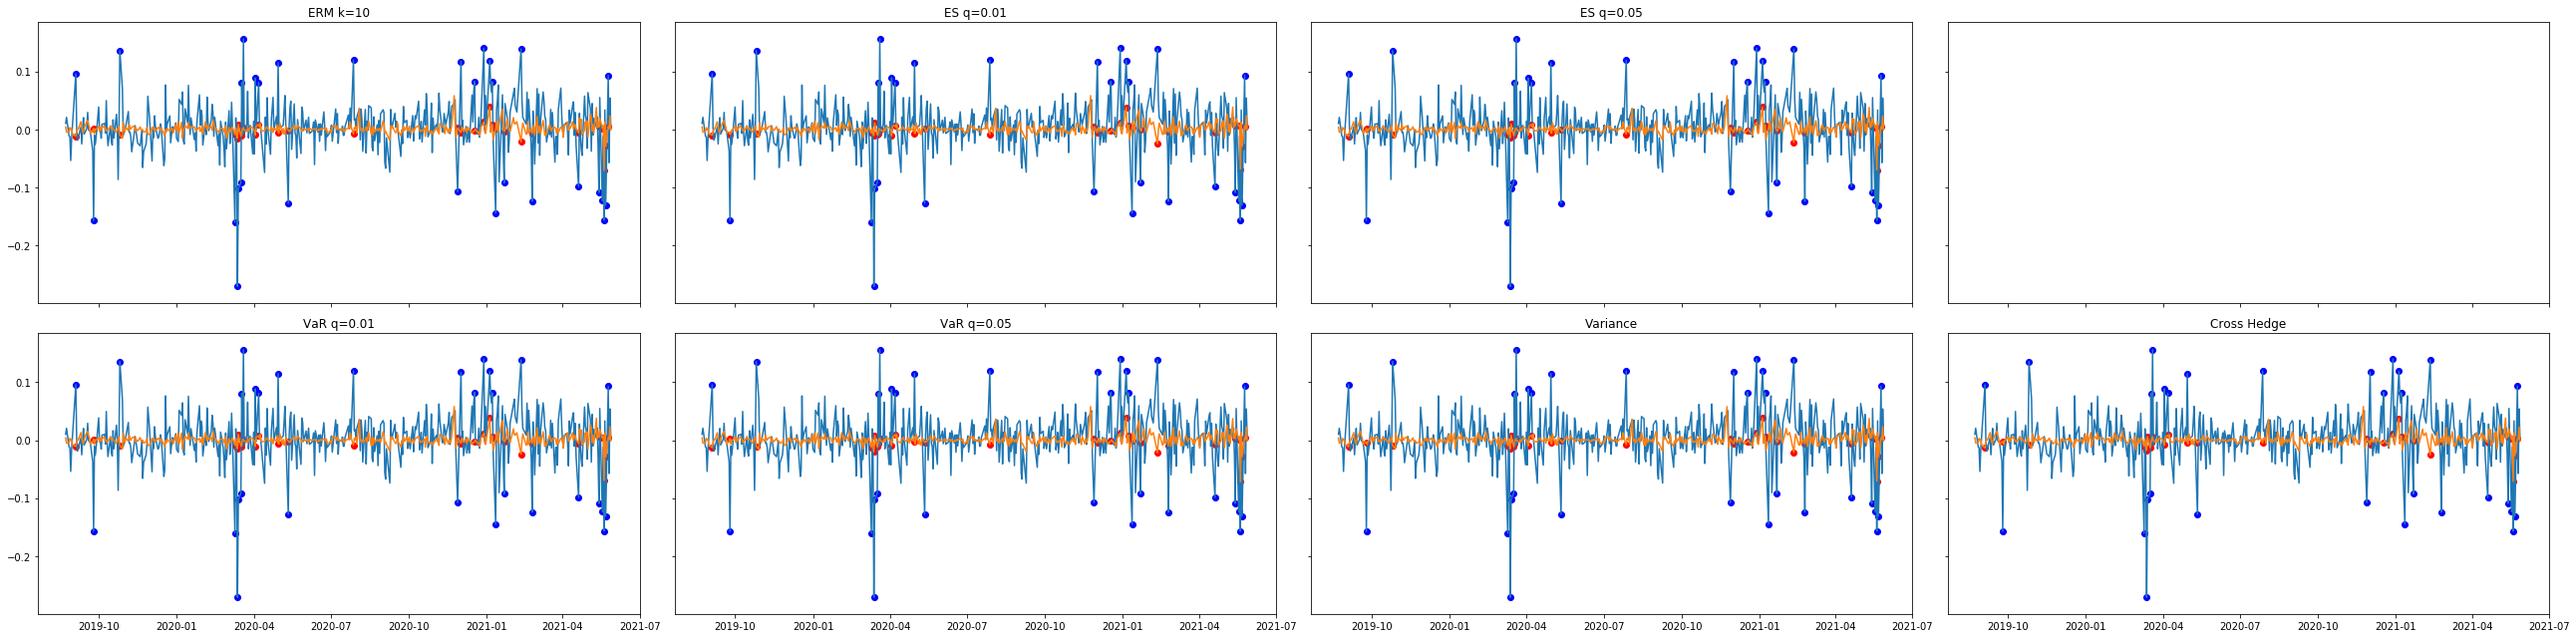

In [166]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(36,9), sharex=True, sharey=True)

data_name = 'BBT_future_CRIX'
thre = -0.01
rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, rm_arr[0]))

print('CRIX')
print("# of observation (out of %i) exceed a threshold of %.2f"%(len(rh_df), thre))

for j, rm in enumerate(rm_arr):
    rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, rm))
    q = 15/len(rh_df.rs)
#     print(np.mean(rh_df.rh))
    ex_id = rh_df.rh <= thre
    print(rm+':', np.sum(ex_id))#, np.mean(rh_df.rh.loc[ex_id]))

    _id = (rh_df.rs <= np.quantile(rh_df.rs,q)) 
    _id_u =  (rh_df.rs >= np.quantile(rh_df.rs,1-q))

    rh_df.Date = pd.to_datetime(rh_df.Date)

    if j <=2 :
    # plt.plot(np.cumsum(rh_df.rh), label='hedged')
    # plt.plot(np.cumsum(rh_df.rs), label='spot')
        ax[0,j].set_title(rm)
        ax[0,j].plot(rh_df.Date, rh_df.rs, label='spot')
        ax[0,j].plot(rh_df.Date, rh_df.rh, label='hedged')

        ax[0,j].scatter(rh_df.Date.loc[_id], rh_df.rs.loc[_id], color='blue')
        ax[0,j].scatter(rh_df.Date.loc[_id], rh_df.rh.loc[_id], color='red')

        ax[0,j].scatter(rh_df.Date.loc[_id_u], rh_df.rs.loc[_id_u], color='blue')
        ax[0,j].scatter(rh_df.Date.loc[_id_u], rh_df.rh.loc[_id_u], color='red')
    else:
        ax[1,j-3].set_title(rm)
        ax[1,j-3].plot(rh_df.Date, rh_df.rs, label='spot')
        ax[1,j-3].plot(rh_df.Date, rh_df.rh, label='hedged')
        
        ax[1,j-3].scatter(rh_df.Date.loc[_id], rh_df.rs.loc[_id], color='blue')
        ax[1,j-3].scatter(rh_df.Date.loc[_id], rh_df.rh.loc[_id], color='red')

        ax[1,j-3].scatter(rh_df.Date.loc[_id_u], rh_df.rs.loc[_id_u], color='blue')
        ax[1,j-3].scatter(rh_df.Date.loc[_id_u], rh_df.rh.loc[_id_u], color='red')

CH = create_CH('BBT_future_CRIX', 'CRIX')


rh_df.Date = pd.to_datetime(rh_df.Date)

rs = CH.iloc[:,6]
rf = CH.iloc[:,5]
rh = CH.iloc[:,-1]
Date = CH.iloc[:,1]

_id = (rs <= np.quantile(rs,q)) 
_id_u =  (rs >= np.quantile(rs,1-q))

ax[1,3].set_title("Cross Hedge")
ax[1,3].plot(Date, rs, label='spot')
ax[1,3].plot(Date, rh, label='hedged')

ax[1,3].scatter(Date.loc[_id], rs.loc[_id], color='blue')
ax[1,3].scatter(Date.loc[_id], rh.loc[_id], color='red')

ax[1,3].scatter(Date.loc[_id_u], rs.loc[_id_u], color='blue')
ax[1,3].scatter(Date.loc[_id_u], rh.loc[_id_u], color='red')
print('Cross Hedge:', np.sum(rh <= thre))

fig.tight_layout()

# of observation (out of 560) exceed a threshold of -0.01
ERM k=10: 240
ES q=0.01: 238
ES q=0.05: 239
VaR q=0.01: 241
VaR q=0.05: 240
Variance: 237
rh1: 236


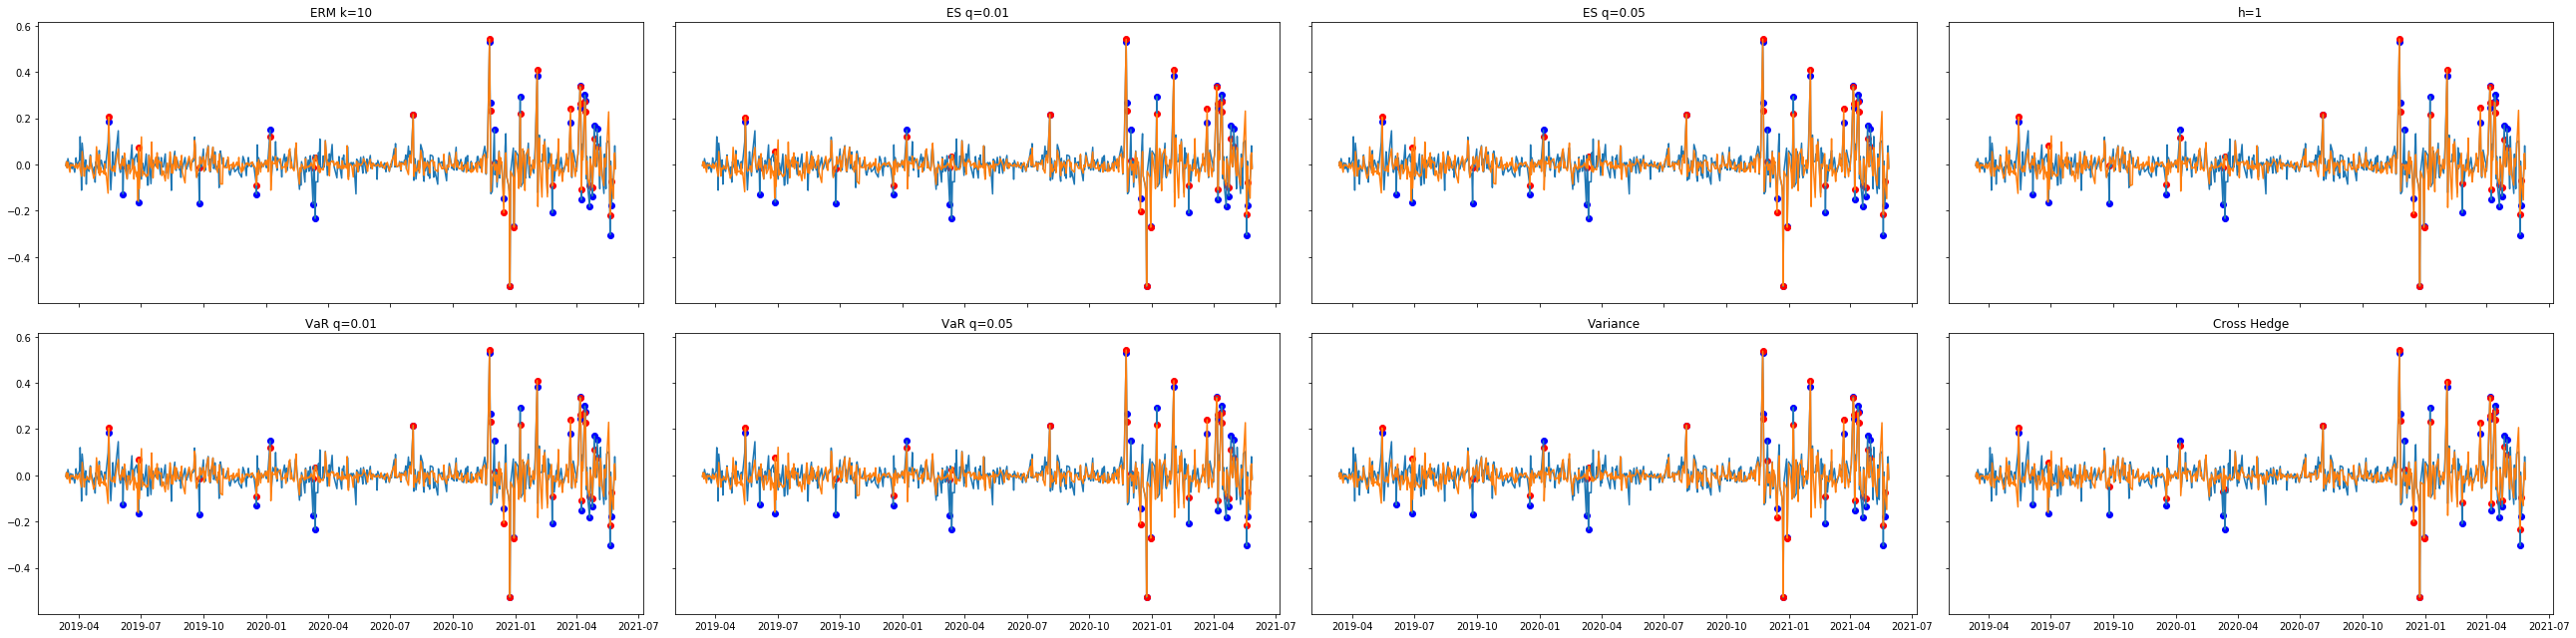

In [170]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(36,9), sharex=True, sharey=True)

data_name = 'BBT_future_Tiingo_xrp'
thre = -0.01
rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, rm_arr[0]))

print("# of observation (out of %i) exceed a threshold of %.2f"%(len(rh_df), thre))

for j, rm in enumerate(rm_arr):
    rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, rm))
    q = 15/len(rh_df.rs)
#     print(np.mean(rh_df.rh))
    print(rm+':', np.sum(rh_df.rh <= thre))
    _id = (rh_df.rs <= np.quantile(rh_df.rs,q)) 
    _id_u =  (rh_df.rs >= np.quantile(rh_df.rs,1-q))

    rh_df.Date = pd.to_datetime(rh_df.Date)

    if j <=2 :
    # plt.plot(np.cumsum(rh_df.rh), label='hedged')
    # plt.plot(np.cumsum(rh_df.rs), label='spot')
        ax[0,j].set_title(rm)
        ax[0,j].plot(rh_df.Date, rh_df.rs, label='spot')
        ax[0,j].plot(rh_df.Date, rh_df.rh, label='hedged')

        ax[0,j].scatter(rh_df.Date.loc[_id], rh_df.rs.loc[_id], color='blue')
        ax[0,j].scatter(rh_df.Date.loc[_id], rh_df.rh.loc[_id], color='red')

        ax[0,j].scatter(rh_df.Date.loc[_id_u], rh_df.rs.loc[_id_u], color='blue')
        ax[0,j].scatter(rh_df.Date.loc[_id_u], rh_df.rh.loc[_id_u], color='red')
    else:
        ax[1,j-3].set_title(rm)
        ax[1,j-3].plot(rh_df.Date, rh_df.rs, label='spot')
        ax[1,j-3].plot(rh_df.Date, rh_df.rh, label='hedged')
        
        ax[1,j-3].scatter(rh_df.Date.loc[_id], rh_df.rs.loc[_id], color='blue')
        ax[1,j-3].scatter(rh_df.Date.loc[_id], rh_df.rh.loc[_id], color='red')

        ax[1,j-3].scatter(rh_df.Date.loc[_id_u], rh_df.rs.loc[_id_u], color='blue')
        ax[1,j-3].scatter(rh_df.Date.loc[_id_u], rh_df.rh.loc[_id_u], color='red')

        
CH = create_CH('BBT_future_Tiingo_xrp', 'xrp')

rh_df.Date = pd.to_datetime(rh_df.Date)

rs = CH.iloc[:,6]
rf = CH.iloc[:,5]
rh = CH.iloc[:,-1]
Date = CH.iloc[:,1]

_id = (rs <= np.quantile(rs,q)) 
_id_u =  (rs >= np.quantile(rs,1-q))

ax[1,3].set_title("Cross Hedge")
ax[1,3].plot(Date, rs, label='spot')
ax[1,3].plot(Date, rh, label='hedged')

ax[1,3].scatter(Date.loc[_id], rs.loc[_id], color='blue')
ax[1,3].scatter(Date.loc[_id], rh.loc[_id], color='red')

ax[1,3].scatter(Date.loc[_id_u], rs.loc[_id_u], color='blue')
ax[1,3].scatter(Date.loc[_id_u], rh.loc[_id_u], color='red')


rh1 = rs - rf
_id = (rs <= np.quantile(rs,q)) 
_id_u =  (rs >= np.quantile(rs,1-q))

ax[0,3].set_title("h=1")
ax[0,3].plot(Date, rs, label='spot')
ax[0,3].plot(Date, rh1, label='hedged')

ax[0,3].scatter(Date.loc[_id], rs.loc[_id], color='blue')
ax[0,3].scatter(Date.loc[_id], rh1.loc[_id], color='red')

ax[0,3].scatter(Date.loc[_id_u], rs.loc[_id_u], color='blue')
ax[0,3].scatter(Date.loc[_id_u], rh1.loc[_id_u], color='red')

print('rh1:', np.sum(rh1 <= thre))

fig.tight_layout()

In [172]:
# historical quantile

np.quantile(rh, 0.05)

-0.0690807424738969

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(36,9), sharex=True, sharey=True)

data_name = 'BBT_future_Tiingo_eth'
thre = -0.05
rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, rm_arr[0]))

print("# of observation (out of %i) exceed a threshold of %.2f"%(len(rh_df), thre))

for j, rm in enumerate(rm_arr):
    rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, rm))
    q = 15/len(rh_df.rs)
#     print(np.mean(rh_df.rh))
    print(rm+':', np.sum(rh_df.rh <= thre))
    _id = (rh_df.rs <= np.quantile(rh_df.rs,q)) 
    _id_u =  (rh_df.rs >= np.quantile(rh_df.rs,1-q))

    rh_df.Date = pd.to_datetime(rh_df.Date)

    if j <=2 :
    # plt.plot(np.cumsum(rh_df.rh), label='hedged')
    # plt.plot(np.cumsum(rh_df.rs), label='spot')
        ax[0,j].set_title(rm)
        ax[0,j].plot(rh_df.Date, rh_df.rs, label='spot')
        ax[0,j].plot(rh_df.Date, rh_df.rh, label='hedged')

        ax[0,j].scatter(rh_df.Date.loc[_id], rh_df.rs.loc[_id], color='blue')
        ax[0,j].scatter(rh_df.Date.loc[_id], rh_df.rh.loc[_id], color='red')

        ax[0,j].scatter(rh_df.Date.loc[_id_u], rh_df.rs.loc[_id_u], color='blue')
        ax[0,j].scatter(rh_df.Date.loc[_id_u], rh_df.rh.loc[_id_u], color='red')
    else:
        ax[1,j-3].set_title(rm)
        ax[1,j-3].plot(rh_df.Date, rh_df.rs, label='spot')
        ax[1,j-3].plot(rh_df.Date, rh_df.rh, label='hedged')
        
        ax[1,j-3].scatter(rh_df.Date.loc[_id], rh_df.rs.loc[_id], color='blue')
        ax[1,j-3].scatter(rh_df.Date.loc[_id], rh_df.rh.loc[_id], color='red')

        ax[1,j-3].scatter(rh_df.Date.loc[_id_u], rh_df.rs.loc[_id_u], color='blue')
        ax[1,j-3].scatter(rh_df.Date.loc[_id_u], rh_df.rh.loc[_id_u], color='red')

        
CH = create_CH('BBT_future_Tiingo_eth', 'eth')


rh_df.Date = pd.to_datetime(rh_df.Date)

rs = CH.iloc[:,6]
rf = CH.iloc[:,5]
rh = CH.iloc[:,-1]
Date = CH.iloc[:,1]

_id = (rs <= np.quantile(rs,q)) 
_id_u =  (rs >= np.quantile(rs,1-q))

ax[1,3].set_title("Cross Hedge")
ax[1,3].plot(Date, rs, label='spot')
ax[1,3].plot(Date, rh, label='hedged')

ax[1,3].scatter(Date.loc[_id], rs.loc[_id], color='blue')
ax[1,3].scatter(Date.loc[_id], rh.loc[_id], color='red')

ax[1,3].scatter(Date.loc[_id_u], rs.loc[_id_u], color='blue')
ax[1,3].scatter(Date.loc[_id_u], rh.loc[_id_u], color='red')

fig.tight_layout()

In [ ]:
result_names

In [ ]:
sns.distplot(rh_df.rs.loc[_id])
sns.distplot(rh_df.rh.loc[_id])

In [ ]:
# 1. boxplots, compare across risk measures
# 2. time series of daily return to see whether we are safe in extreme events
# 3. statistics of those extremes (subset of the samples, those dots we identified)

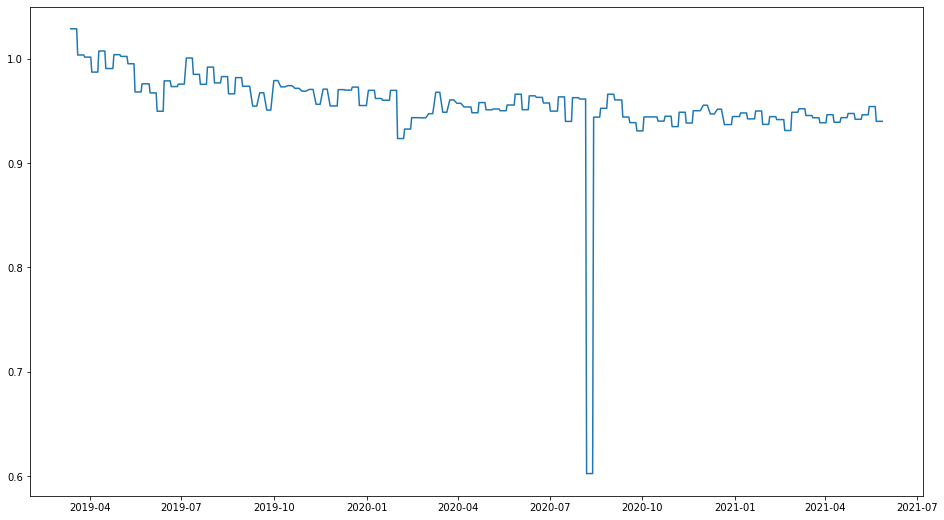

In [704]:
i=0
data_name = result_names[i]
coin_name = coin_names[i]
rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, objective))
rh_df.Date = pd.to_datetime(rh_df.Date)

plt.figure(figsize=(16,9))
plt.plot(rh_df.Date, rh_df.h)